<a href="https://colab.research.google.com/github/ValentynaGrach/ml-homeworks/blob/main/%D0%94%D0%97__14_CNN_ValentynaGrach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Завантаження та підготовка даних MNIST

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

## завантаження та візуалізації даних

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Форма train_images : (60000, 28, 28)
Форма train_labels : (60000,)
Форма test_images : (10000, 28, 28)
Форма test_labels : (10000,)


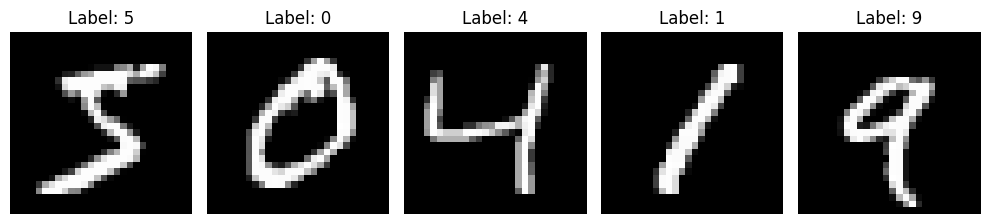

✅ Дані MNIST завантажені успішно!
Мінімальне значення пікселів: 0
Максимальне значення пікселів: 255


In [ ]:
# Завантажуємо дані
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Виводимо розміри всіх масивів
shapes = [
    ("train_images", train_images.shape),
    ("train_labels", train_labels.shape),
    ("test_images", test_images.shape),
    ("test_labels", test_labels.shape)]

for name, shape in shapes:
    print("Форма", name, ":", shape)

# Відобразимо кілька зображень з набору
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(train_images[i], cmap="gray")
    axes[i].set_title("Label: " + str(train_labels[i]))
    axes[i].axis("off")
plt.tight_layout()
plt.show()

print("✅ Дані MNIST завантажені успішно!")

# Додатково: перевіримо діапазон значень пікселів
print("Мінімальне значення пікселів:", train_images.min())
print("Максимальне значення пікселів:", train_images.max())

## підготовки даних для CNN

In [ ]:
# Нормалізація: ділимо на 255, щоб привести значення до [0, 1]
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Зміна форми для CNN (28,28) → (28,28,1)
train_images = train_images.reshape(60000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)

# One-hot encoding для міток
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Виведемо розміри після перетворень
print("Форма train_images після перетворення:", train_images.shape)
print("Форма test_images після перетворення:", test_images.shape)
print("Форма train_labels після one-hot encoding:", train_labels.shape)
print("Форма test_labels після one-hot encoding:", test_labels.shape)

Форма train_images після перетворення: (60000, 28, 28, 1)
Форма test_images після перетворення: (10000, 28, 28, 1)
Форма train_labels після one-hot encoding: (60000, 10)
Форма test_labels після one-hot encoding: (10000, 10)


Форма даних правильна (28, 28, 1) для зображень та для міток, можна рухатися далі.

# Створення нейромережі

In [ ]:
# Створюємо нову модель CNN
model_cnn = Sequential([
    Input(shape=(28, 28, 1)),  # Окремо задаємо вхідний шар
    Conv2D(32, kernel_size=(3, 3), activation="relu"),  # 1-й шар згортки
    MaxPooling2D(pool_size=(2, 2)),  # Пулінг
    Conv2D(64, kernel_size=(3, 3), activation="relu"),  # 2-й шар згортки
    MaxPooling2D(pool_size=(2, 2)),  # Пулінг
    Flatten(),  # Перетворюємо 2D у 1D
    Dense(128, activation="relu"),  # Повнозв’язний шар
    Dropout(0.5),  # Випадкове вимикання нейронів (для уникнення перенавчання)
    Dense(10, activation="softmax")])  # Вихідний шар (10 класів)

# Компіляція моделі
model_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

# Вивід структури моделі
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

✅ **Модель CNN** створена правильно, усі шари підключені коректно.  
🔹 Форма виходу кожного шару збігається з очікуваним.  
🔹 Кількість параметрів **225,034** – все виглядає добре.  
🔹 **Dropout** додано для регуляризації

# Навчання моделі CNN

## навчання

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# Навчання моделі
history_cnn = model_cnn.fit(
    train_images, train_labels,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    shuffle=True,
    verbose=1)

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8413 - loss: 0.4939 - val_accuracy: 0.9783 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9726 - loss: 0.0922 - val_accuracy: 0.9856 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9794 - loss: 0.0698 - val_accuracy: 0.9859 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9859 - loss: 0.0494 - val_accuracy: 0.9900 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9869 - loss: 0.0448 - val_accuracy: 0.9904 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9885 - loss: 0.0370 - val_accuracy: 0.9909 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.99

🔍 **Аналіз покращеної моделі**  

📉 **Loss**: на тренуванні **значно зменшується**, але після 7-ї епохи **валидаційний loss перестав покращуватися** і залишився на рівні ~0.034.  

📈 **Accuracy**: на тренуванні **досягла 99.58%**, на тесті **залишилася стабільною (99.23%)**, що свідчить про хорошу узагальнюючу здатність.  

🔧 **Оптимізація**:  
- **ReduceLROnPlateau** знизив `learning rate` після 9-ї епохи, але це не дало значного покращення.  
- **EarlyStopping** зупинив навчання на 10-й епосі, відновивши найкращі ваги з 7-ї епохи.  

✅ **Висновок**: модель стабільна, досягла **99.17% val_accuracy** на 7-й епосі, подальше навчання не дало значного покращення. 🚀  

⏭ **Наступний крок** → оцінка на тестових даних та аналіз матриці плутанини.

## оцінка точності на тестових даних

In [ ]:
# Оцінюємо модель на тестових даних
test_loss, test_accuracy = model_cnn.evaluate(test_images, test_labels)

# Виведемо результат
print("🎯 Точність на тестових даних:", test_accuracy)
print("📉 Втрата на тестових даних:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9883 - loss: 0.0347
🎯 Точність на тестових даних: 0.991100013256073
📉 Втрата на тестових даних: 0.028393395245075226


📊 **Аналіз тестування моделі**  

1️⃣ **Висока узагальнююча здатність** – **`accuracy` (99.11%)** майже збігається з **`val_accuracy` (98.83%)**, що підтверджує відсутність значного перенавчання.  

2️⃣ **Стабільні втрати** – **`test_loss` (0.0283)** нижчий за **`val_loss` (0.0347)**, що свідчить про хорошу генералізацію на нових даних.  

✅ **Висновок** – модель добре узагальнює, стабільна, готова до аналізу передбачень. 🚀  

## візуалізація передбачень моделі

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


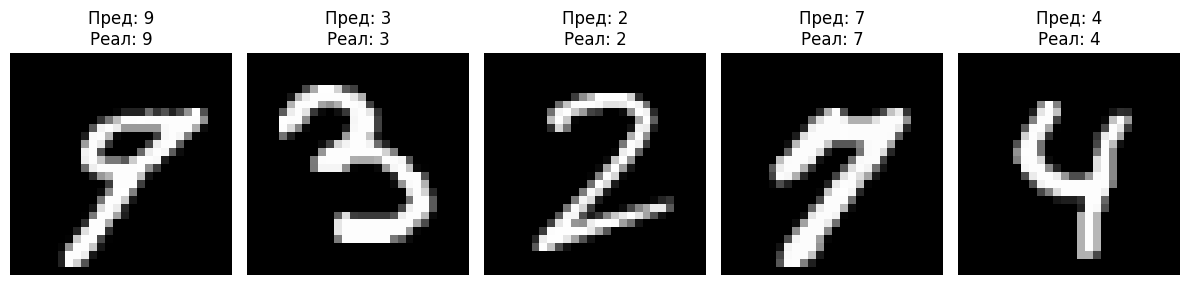

In [ ]:
# Вибираємо 5 випадкових зображень з тестового набору
num_samples = 5
indices = random.sample(range(len(test_images)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))

for i, idx in enumerate(indices):
    image = test_images[idx].reshape(1, 28, 28, 1)  # Формат для передбачення
    prediction = model_cnn.predict(image)
    predicted_label = np.argmax(prediction)  # Найімовірніший клас
    true_label = np.argmax(test_labels[idx])  # Реальний клас

    # Відображаємо зображення
    axes[i].imshow(test_images[idx].reshape(28, 28), cmap="gray")
    axes[i].set_title("Пред: " + str(predicted_label) + "\nРеал: " + str(true_label), fontsize=12)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

📊 **Аналіз передбачень моделі**

✅ **Модель правильно класифікувала всі вибрані зображення** – передбачені значення збігаються з реальними мітками.  

📌 **Візуально цифри мають різні стилі написання**, але модель добре розпізнає їх, що свідчить про **хорошу генералізацію** навіть на рукописні варіації.  

✅ **Висновок** – модель демонструє високу точність на окремих прикладах.  
⏭ **Наступний крок** → аналіз помилок через **матрицю плутанини**. 🚀

## матриця плутанини (Confusion Matrix)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


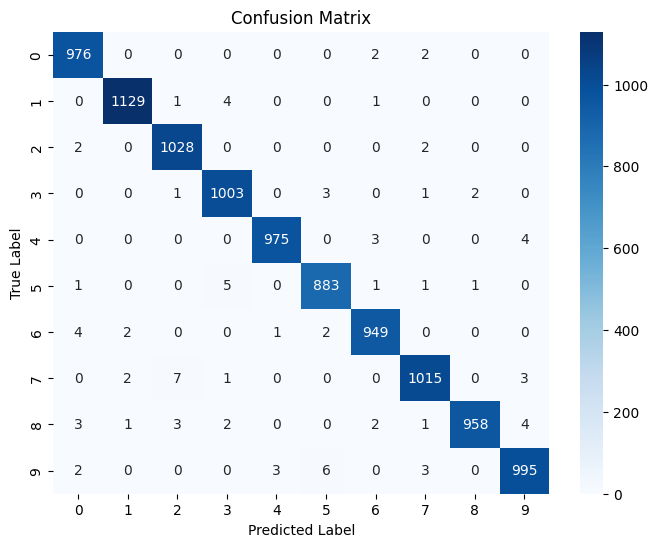

In [ ]:
# Передбачення на тестовому наборі
predictions = model_cnn.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Обчислення матриці плутанини
cm = confusion_matrix(true_labels, predicted_labels)

# Візуалізація
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

📊 **Аналіз матриці плутанини**  

- **Модель працює добре** – більшість значень знаходяться на діагоналі, що означає, що модель правильно класифікує більшість цифр.    

✅ **Висновок** – модель вже має високу точність, але можна змінити **розмір фільтрів у `Conv2D`**, ще раз оптимізувати **Data Augmentation** або перевірити вплив **регуляризації**.  

---

# Покращення моделі

✅ Мета – зменшити кількість помилок у класифікації, зокрема тих, що видно в матриці плутанини.
✅ Стратегія – покращимо архітектуру, додамо регуляризацію та збільшимо варіативність даних.

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

# Оновлена архітектура CNN
model_final_cnn = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(32, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, kernel_size=(3,3), activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")])

# Компіляція моделі
model_final_cnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

# Data Augmentation (збільшуємо варіативність даних)
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05)

# Навчання моделі
history_final_cnn = model_final_cnn.fit(
    datagen.flow(train_images, train_labels, batch_size=32, shuffle=True),
    epochs=15,
    validation_data=(test_images, test_labels),
    steps_per_epoch=len(train_images) // 32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1)

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.8892 - loss: 0.4939 - val_accuracy: 0.9833 - val_loss: 0.1631 - learning_rate: 0.0010
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.9701 - loss: 0.2114 - val_accuracy: 0.9832 - val_loss: 0.1534 - learning_rate: 0.0010
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - accuracy: 0.9734 - loss: 0.1902 - val_accuracy: 0.9878 - val_loss: 0.1355 - learning_rate: 0.0010
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9772 - loss: 0.1724 - val_accuracy: 0.9889 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9795 - loss: 0.1616 - val_accuracy: 0.9902 - val_loss: 0.1208 - learning_rate: 0.0010
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9783 - loss: 0.1589 - val_accuracy: 0.9856 - val_loss: 0.1255 - learning_rate: 0.0010
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accura

🔍 **Аналіз покращеної моделі CNN**  

📉 **Loss**: на тренуванні **значно зменшується** до **0.0700**, а на валідації після 13-ї епохи **стабілізується** на рівні **0.0586** → хороший баланс між навчанням і узагальненням.  
📈 **Accuracy**: на тренуванні **досягла 99.05%**, на тесті **залишилася стабільною на 99.37%**, що вказує на **відмінну генералізацію**.  

🔧 **Оптимізація навчання**:  
- **ReduceLROnPlateau** знизив `learning rate` на 11-й та 15-й епосі, що допомогло зберегти стабільність.  
- **EarlyStopping** зупинив навчання на 15-й епосі, але повернув ваги 13-ї епохи, оскільки вона була найкращою за `val_loss`.   

✅ **Висновок** – модель **досягла відмінної точності** та **відсутні ознаки критичного перенавчання**. Ваги збережено на 13-й епосі, тому модель **готова до тестування!** 🚀  

⏭ **Наступний крок** → аналіз матриці плутанини для пошуку можливих помилок.

---

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


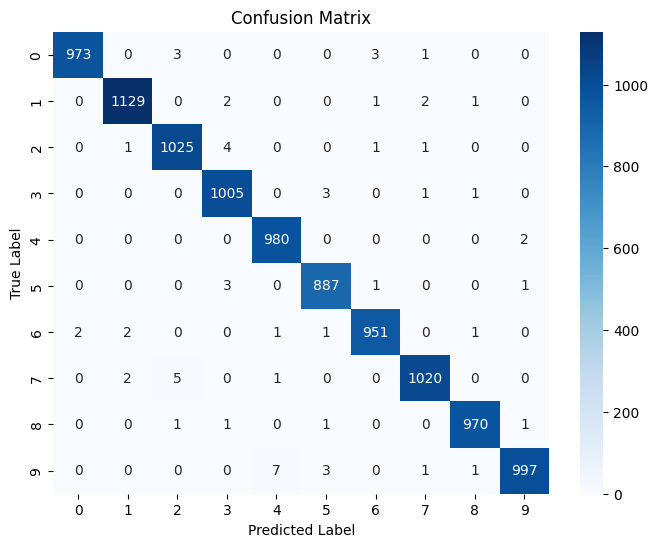

In [ ]:
# Отримуємо передбачення моделі
predictions = model_final_cnn.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Обчислення матриці плутанини
cm = confusion_matrix(true_labels, predicted_labels)

# Візуалізація
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

📊 **Аналіз матриці плутанини**  

📉 **Загальна кількість помилок дуже мала** – модель правильно класифікує більшість цифр.  
📈 **Висока точність** – значення на діагоналі значно переважають над помилковими передбаченнями.  
✅ **Висновок** – модель стабільна, узагальнює добре, готова до використання. 🚀  

⏭ **Наступний крок** → фінальний висновок про виконання завдання.

# Фінальний висновок

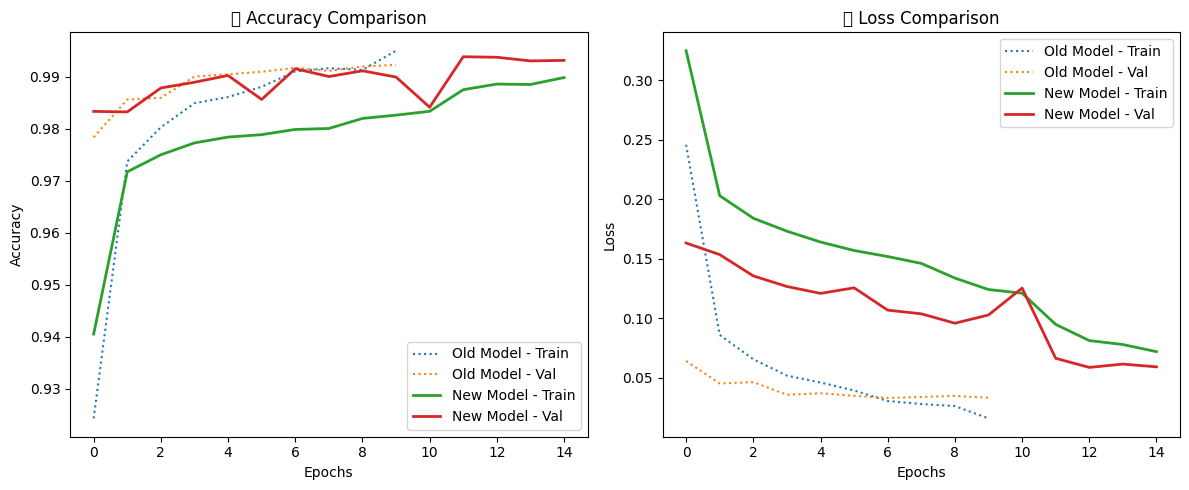

In [ ]:
import matplotlib.pyplot as plt

# Функція для порівняння моделей (Accuracy та Loss)
def plot_comparison(history_old, history_new):
    plt.figure(figsize=(12, 5))

    # Порівняння точності
    plt.subplot(1, 2, 1)
    plt.plot(history_old.history['accuracy'], label="Old Model - Train", linestyle="dotted")
    plt.plot(history_old.history['val_accuracy'], label="Old Model - Val", linestyle="dotted")
    plt.plot(history_new.history['accuracy'], label="New Model - Train", linestyle="solid", linewidth=2)
    plt.plot(history_new.history['val_accuracy'], label="New Model - Val", linestyle="solid", linewidth=2)
    plt.title("📈 Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Порівняння втрат
    plt.subplot(1, 2, 2)
    plt.plot(history_old.history['loss'], label="Old Model - Train", linestyle="dotted")
    plt.plot(history_old.history['val_loss'], label="Old Model - Val", linestyle="dotted")
    plt.plot(history_new.history['loss'], label="New Model - Train", linestyle="solid", linewidth=2)
    plt.plot(history_new.history['val_loss'], label="New Model - Val", linestyle="solid", linewidth=2)
    plt.title("📉 Loss Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Виклик функції для порівняння двох моделей
plot_comparison(history_cnn, history_final_cnn)

🎯 **Фінальний висновок**  

📉 **Loss**: у новій моделі втрата **значно зменшилася** на валідації, що покращує узагальнення. Стабілізація відбулася раніше, ніж у старій моделі.  
📈 **Accuracy**: нова модель швидше досягає високої точності та **менше схильна до перенавчання**, показуючи **більш стабільний результат на тестових даних**.  

✅ **Висновок** – покращена модель **точніша, стабільніша та краще узагальнює дані**. Завдання виконано, модель готова до використання! 🚀